Laboratorium Nr.3 

Asymilacja danych (data assimilation) 

 

1. Wybrać parametry dla swojego modelu (model bazowy), tak by produkowały jak najbardziej złożoną trajektorię. Na wykresie pokazać, jak wygląd ta zmienność w czasie każdej zmiennej dynamicznej x. Zrobić wykres 3D w przestrzeni fazowej. Wybrać także drugi model (startowy) z wyraźnie innymi parametrami, ale nie drastycznie innymi! UWAGA: Parametrami są także wartości początkowe x(0). 

 

OPROGRAMOWANIE: 

Rekomenduję użycie repozytorium pyPESTO.  Użyteczne linki: 

pyPESTO/doc/example/fixed_parameters.ipynb at main · ICB-DCM/pyPESTO · GitHub 

GitHub - nansencenter/DA-tutorials: Tutorials on data assimilation (DA) and the EnKF 

AMICI in pyPESTO — pyPESTO documentation 

SciMLSensitivity.jl/docs/src/tutorials/parameter_estimation_ode.md at master · SciML/SciMLSensitivity.jl · GitHub 

ApplNumComp/L13 Parameter Estimation in Python.md at master · ashleefv/ApplNumComp · GitHub 

global optimization - How to fit the parameters of differential equations with known data? - MathOverflow 

 

 

# Model

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def predator_prey_ode(t, y, params):
    """
    Defines the ODEs for the predator-prey system.

    Parameters:
    - t: Time
    - y: Current populations [population_A, population_B, population_C]
    - params: A dictionary containing all model parameters.

    Returns:
    - dydt: Derivatives [dA/dt, dB/dt, dC/dt]
    """
    A, B, C = y  # Unpack populations


    # Ensure populations are non-negative
    A = max(0, A)
    B = max(0, B)
    C = max(0, C)
    
    # Determine the most populated species and reduce its hunting efficiency
    most_populated = max(A, B, C)
    hunting_efficiency_factor = 1 - params['hunting_efficiency_reduction'] * (most_populated / (most_populated + 1))

    # Compute derivatives
    dA_dt = params['prey_growth_rate'] * A - hunting_efficiency_factor * params['predation_rate_A_by_B'] * A * B
    dB_dt = (
        -params['mortality_rate_B'] * B +
        hunting_efficiency_factor * params['reproduction_rate_B_from_A'] * A * B -
        hunting_efficiency_factor * params['predation_rate_B_by_C'] * B * C
    )
    dC_dt = (
        -params['mortality_rate_C'] * C +
        hunting_efficiency_factor * params['reproduction_rate_C_from_B'] * B * C -
        hunting_efficiency_factor * params['predation_rate_A_on_C'] * A * C
    )
    return [dA_dt, dB_dt, dC_dt]

In [83]:
# Define parameters with new hunting efficiency factor
parameters = {
    #A
    'prey_growth_rate': 0.02,                     # Growth rate of Species A (prey)
    'predation_rate_A_by_B': 0.005,               # Base predation rate of Species A by Species B
    
    #B
    'mortality_rate_B': 0.05,                     # Mortality rate of Species B
    'predation_rate_B_by_C': 0.002,               # Base predation rate of Species B by Species C
    'reproduction_rate_B_from_A': 0.01,           # Reproduction rate of Species B from consuming A
    
    #C
    'mortality_rate_C': 0.02,                     # Mortality rate of Species C
    'reproduction_rate_C_from_B': 0.003,           # Reproduction rate of Species C from consuming B
    'predation_rate_A_on_C': 0.0001,               # Predation or harm rate of Species A on Species C
   
    # all
    'hunting_efficiency_reduction': 0.4,          # Reduction factor for most populated species' hunting efficiency

    #initial
    'initial_population_A': 40,                   # Initial population of Species A (prey)
    'initial_population_B': 20,                   # Initial population of Species B (predator 1)
    'initial_population_C': 5,                   # Initial population of Species C (predator 2)
}


In [84]:
for p in list(parameters.keys())[:-6]:
    parameters[p] = parameters[p] 

In [85]:
import matplotlib.pyplot as plt

def plot_results(t, pop_A, pop_B, pop_C):
    """
    Plots the results of a predator-prey simulation.

    Parameters:
    - t: Array of time points
    - pop_A, pop_B, pop_C: Population dynamics for Species A, B, and C
    """
    plt.figure(figsize=(12, 7))
    plt.plot(t, pop_A, label='Species A (Prey)', color='green')
    plt.plot(t, pop_B, label='Species B (Predator 1)', color='blue')
    plt.plot(t, pop_C, label='Species C (Predator 2)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Predator-Prey Dynamics with Hunting Efficiency Reduction')
    plt.legend()
    plt.grid()
    plt.show()

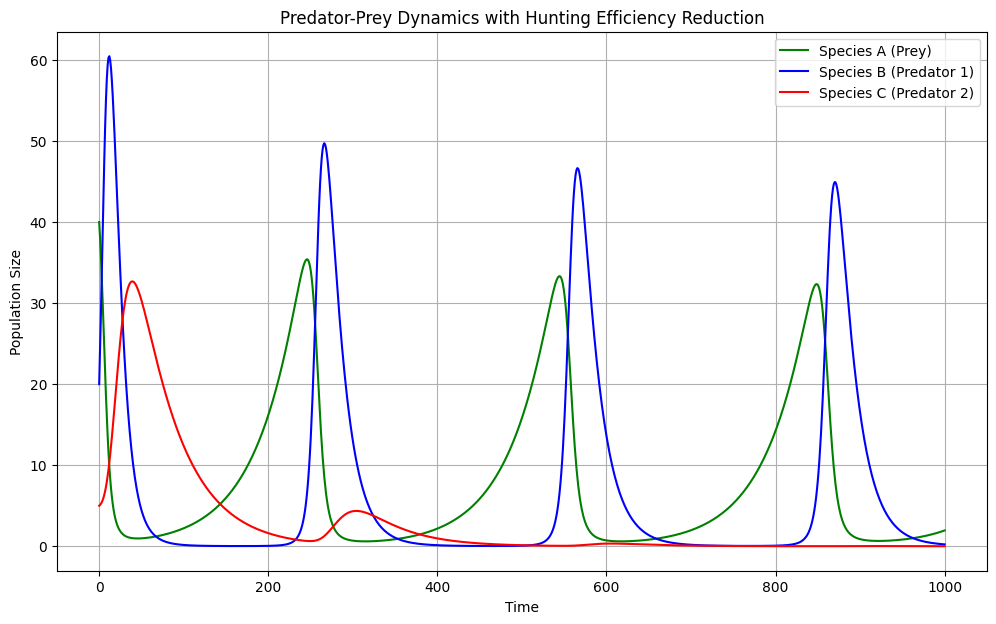

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e+00 ...  9.990e+02  1.000e+03]
        y: [[ 4.000e+01  3.815e+01 ...  1.915e+00  1.952e+00]
            [ 2.000e+01  2.401e+01 ...  2.388e-01  2.304e-01]
            [ 5.000e+00  5.092e+00 ...  6.371e-03  6.247e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 501
     njev: 0
      nlu: 0

In [86]:
from scipy.integrate import solve_ivp
import numpy as np


def evaluate_model_and_plot( 
    model, 
    params,
    y_0,
    t_calc_range =(0, 1000),
    t_eval = np.linspace(0, 1000, 1000),
    plot=False
    ):
    solution = solve_ivp(
        fun=lambda t, y: model(t, y, params),
        t_span=t_calc_range,
        y0=y_0,
        t_eval=t_eval,
        method="LSODA"
    )
    if plot:
        plot_results(solution.t, solution.y[0], solution.y[1], solution.y[2])
    return solution

evaluate_model_and_plot(
    predator_prey_ode, 
    parameters, 
    [   
     parameters['initial_population_A'], 
     parameters['initial_population_B'], 
     parameters['initial_population_C']
    ],
    plot=True)

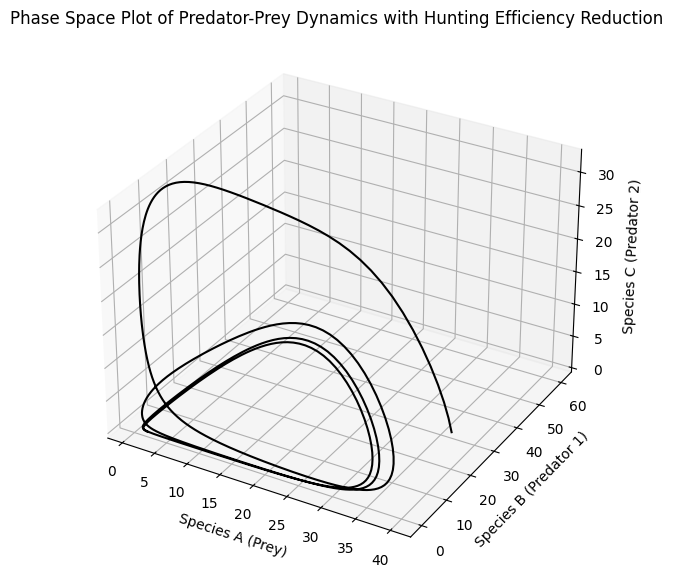

In [87]:
#phase space calc
def phase_space_plot(params):
    sol = evaluate_model_and_plot(
        predator_prey_ode, 
        params, 
        [   
        params['initial_population_A'], 
        params['initial_population_B'], 
        params['initial_population_C']
        ],
        plot=False)

    pop_A = sol.y[0]
    pop_B = sol.y[1]
    pop_C = sol.y[2]

    #phase space plot 3d
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(pop_A, pop_B, pop_C, color='black')
    ax.set_xlabel('Species A (Prey)')
    ax.set_ylabel('Species B (Predator 1)')
    ax.set_zlabel('Species C (Predator 2)')
    plt.title('Phase Space Plot of Predator-Prey Dynamics with Hunting Efficiency Reduction')
    plt.show()
phase_space_plot(parameters)

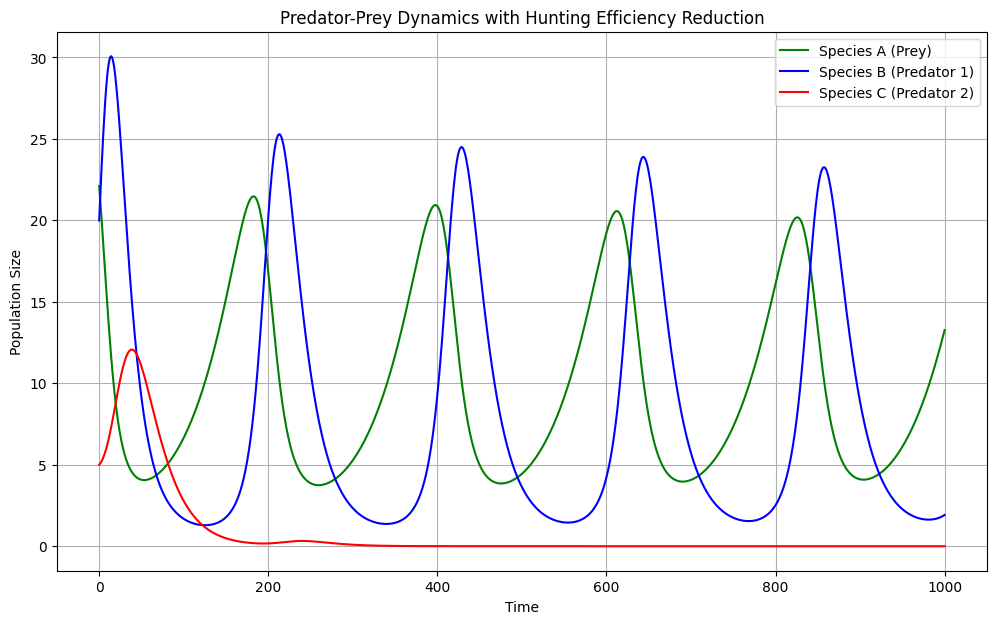

In [89]:
base_model_params = parameters.copy()
start_model_params = parameters.copy()


#apply gaussian noise to parameters
for p in list(start_model_params.keys())[:-2]:
    start_model_params[p] = start_model_params[p] * (1 + np.random.normal(0, 0.4))
    
#run model with noise
sol = evaluate_model_and_plot(
    predator_prey_ode, 
    start_model_params, 
    [   
     start_model_params['initial_population_A'], 
     start_model_params['initial_population_B'], 
     start_model_params['initial_population_C']
    ],
    plot=True)


2. Wybrać odcinek czasu, który nazwiemy przedziałem uczenia. 


In [90]:
learning_interval = (200,400)


3. Tak jak pokazano na rysunku poniżej dokonać próbkowania dla każdej zmiennej dynamicznej w zdefiniowanym przedziale uczenia (B) dla modelu bazowego. Zamiast wielu zmiennych dynamicznych można zdefiniować pewną pojedynczą miarę (np. w przypadku, gdy zmienne dynamiczne opisują dynamikę różnych populacji taką pojedynczą miarą może być ich suma, lub tylko jedna najważniejsza zmienna dynamiczna). Proszę wybrać rozsądną gęstość próbkowania tzn taką by oddawała on mniej więcej kształt krzywej. 


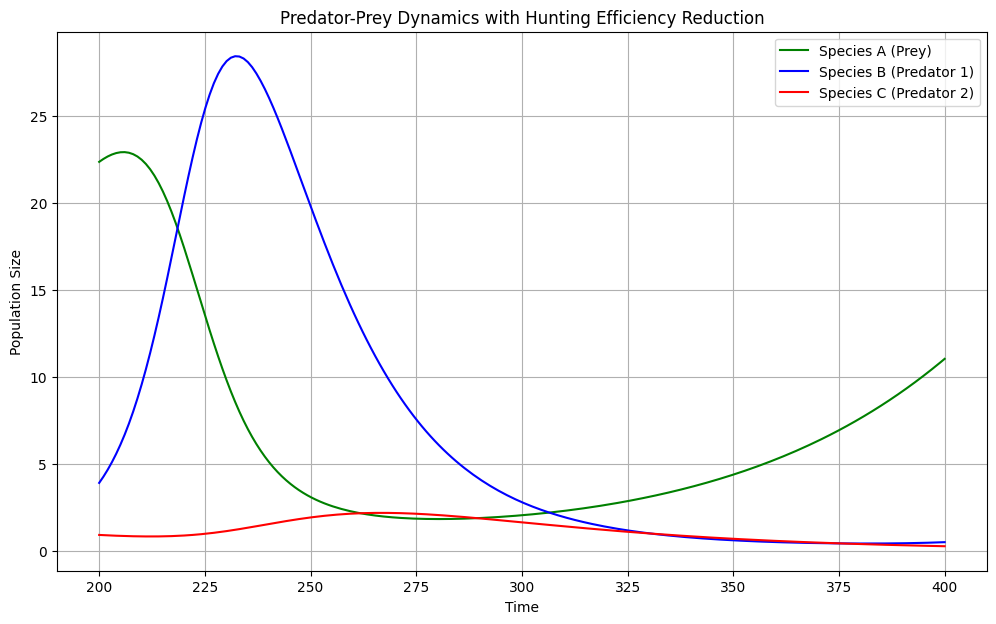

In [93]:
training_sol = evaluate_model_and_plot(
        predator_prey_ode, 
        base_model_params, 
        [   
            start_model_params['initial_population_A'], 
            start_model_params['initial_population_B'], 
            start_model_params['initial_population_C']
        ],
        t_eval= np.linspace(learning_interval[0], learning_interval[1],learning_interval[1]- learning_interval[0]),
        plot=True
    )



4. Na podstawie wygenerowanych danych przy pomocy metod asymilacji danych (patrz niżej) dopasować model startowy do tych danych (model dopasowany). 

abc assimilation code

In [154]:
from scipy.stats import uniform
#priority queue
from queue import PriorityQueue


observed_variables = [0]


def abc_assimilation(
        observed_data,
        t_eval, # t_eval -  training range
        params_prior,
        num_samples
    ):
    
    accepted_params = PriorityQueue()
    for _ in range(num_samples):
        sampled_params = {
            key: uniform.rvs(loc=prior[0], scale=prior[1] - prior[0], random_state=1)
            for key, prior in params_prior.items()
        }
        sol_sim = solve_ivp(
            predator_prey_ode,
            (0, 800),
            [   
                sampled_params['initial_population_A'], 
                sampled_params['initial_population_B'], 
                sampled_params['initial_population_C']
            ], 
            args=(sampled_params,),
            method="BDF",
            t_eval=t_eval,
        )

        distance = 0
        for i, var_idx in enumerate(observed_variables):
            distance += np.linalg.norm(sol_sim.y[var_idx] - observed_data[i])
        accepted_params.put((distance, sampled_params))
        
    return [ accepted_params.get() for _ in range(5)]

abc evaluation

In [146]:
params_prior = {key: (prior * 0.6, prior * 1.4) for key, prior in start_model_params.items()}
num_samples = 1000


accepted_params_abc = abc_assimilation(
    training_sol.y, 
    np.linspace( learning_interval[0], learning_interval[1], learning_interval[1]- learning_interval[0] ),
    params_prior,
    num_samples
)

estimated_params_abc = {
    key: np.mean([p[key] for _dist, p in accepted_params_abc]) for key in params_prior
}


abc plot

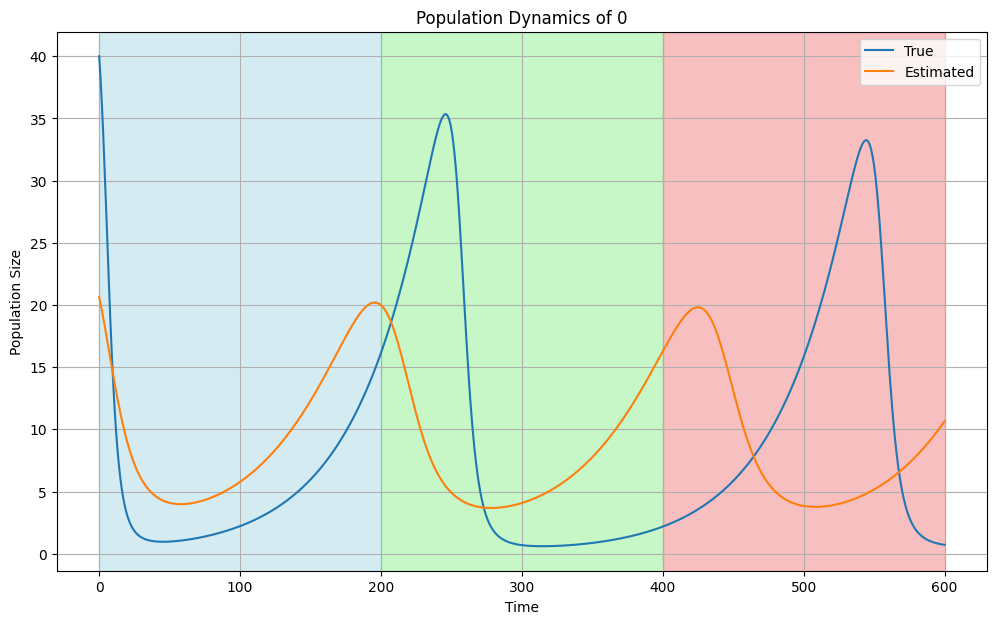

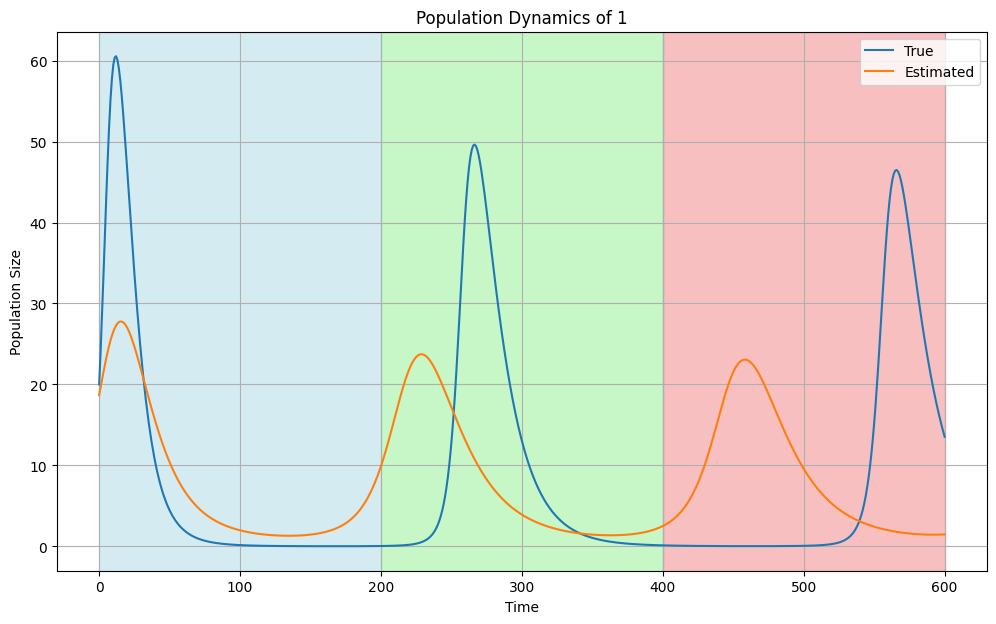

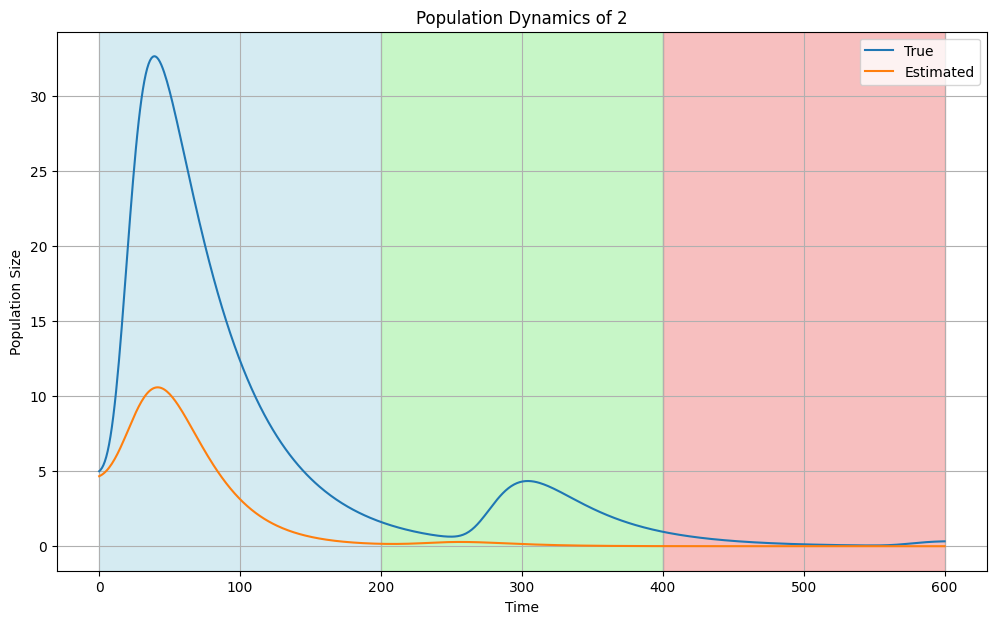

In [147]:
#plotting
t_span = (0, 600)
t_eval = np.linspace(0, 600, 600)

y_values, y_values_abc = (
    solve_ivp(
        predator_prey_ode,
        t_span,
        [   
            params['initial_population_A'], 
            params['initial_population_B'], 
            params['initial_population_C']
        ],
        args=(params,),
        method="BDF",
        t_eval=t_eval,
    ).y
    for params in (base_model_params, estimated_params_abc)
)

import matplotlib.pyplot as plt

intervals = [(0, 200, "lightblue"), (200, 400, "lightgreen"), (400, 600, "lightcoral")]
for i in range(3):
    plt.figure(figsize=(12, 7))
    plt.plot(t_eval, y_values[i], label="True")
    plt.plot(t_eval, y_values_abc[i], label="Estimated")
    for start, end, color in intervals:
        plt.axvspan(start, end, color=color, alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Population Size")
    plt.title(f"Population Dynamics of {i}")
    plt.legend()
    plt.grid()
    plt.show()


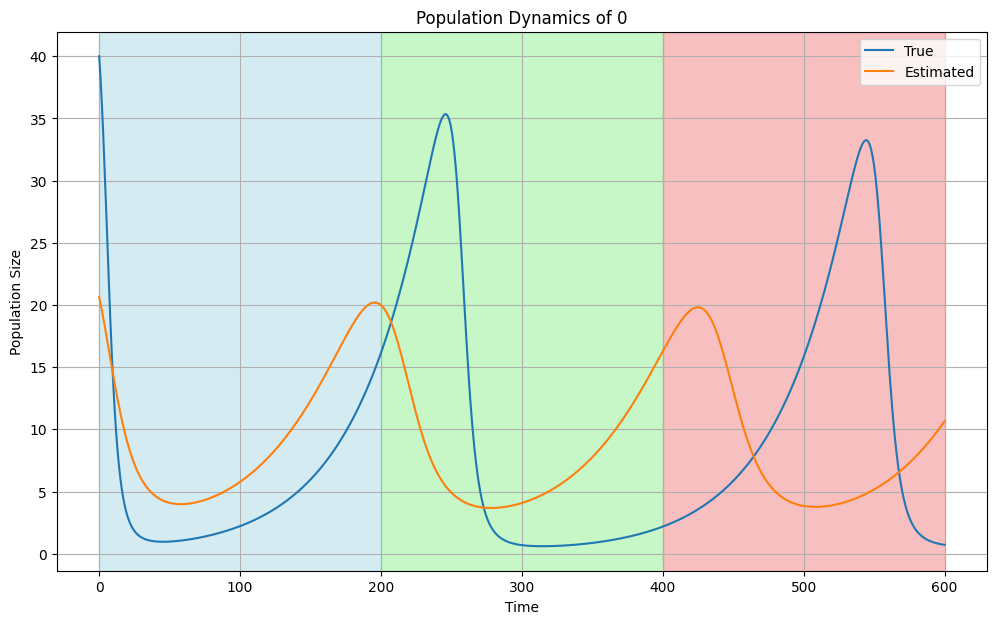

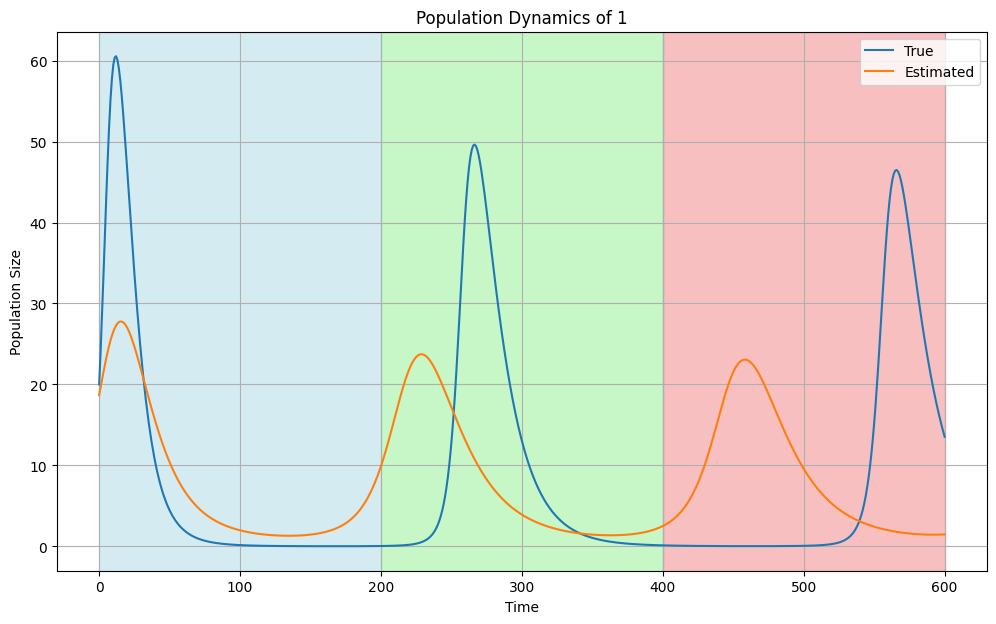

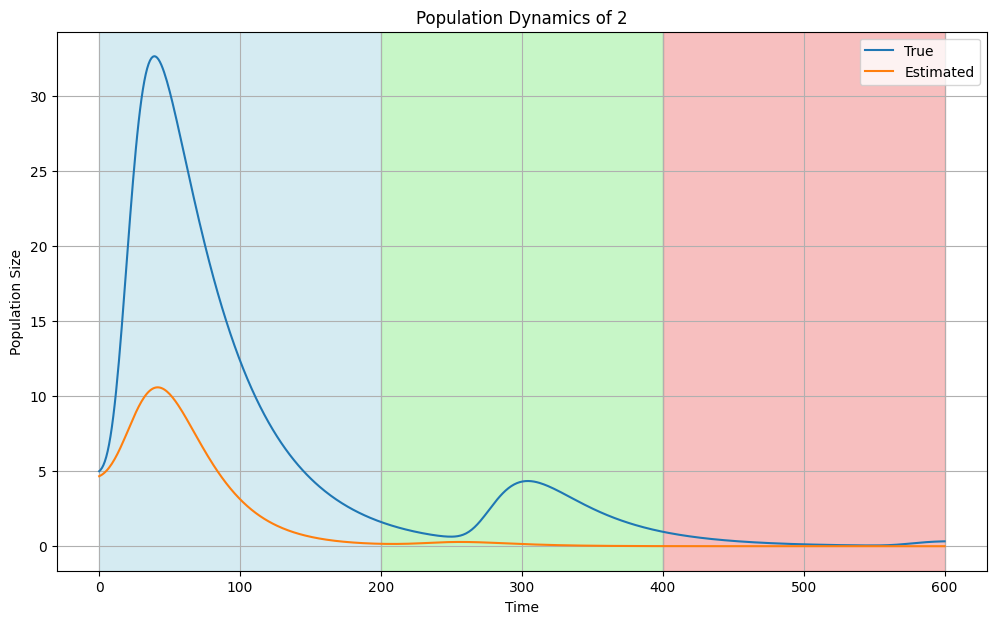

In [160]:
from scipy.optimize import minimize


def cost_function_3dvar(
    params_vec,
    observed_data,
    t_eval, # training range
    params_template,
    params_prior,
    var,
):
    params = params_template.copy()
    i = 0
    for key in params:
        params[key] = params_vec[i]
        i += 1

    sol_sim = solve_ivp(
        predator_prey_ode,
        (0, max(t_eval)),
        [ 
            params['initial_population_A'],
            params['initial_population_B'],
            params['initial_population_C']
        ],
        args=(params,),
        t_eval=t_eval,
        method="Radau",
    )

    obs_cost = 0
    if len(sol_sim.y) > 0:
        for j, var_idx in enumerate(observed_variables):
            obs_cost += np.sum(
                (sol_sim.y[var_idx] - observed_data[j][: sol_sim.y[var_idx].shape[0]])
                ** 2
                / var
            )
    else:
        obs_cost = 1e7

    prior_cost = 0
    i = 0
    for key in params:
        mean_prior = (params_prior[key][0] + params_prior[key][1]) / 2
        std_prior = (params_prior[key][1] - params_prior[key][0]) / 6
        prior_cost += ((params_vec[i] - mean_prior) / std_prior) ** 2
        i += 1

    return obs_cost + prior_cost


std = 1
params_template = base_model_params.copy()
params_vec_init = [
    uniform.rvs(loc=prior[0], scale=prior[1] - prior[0], random_state=1)
    for prior in params_prior.values()
]

result = minimize(
    cost_function_3dvar,
    params_vec_init,
    args=(
        training_sol.y,
        np.linspace(200, 400, 200),
        params_template,
        params_prior,
        std**2,
    ),
)

estimated_params_3dvar = params_template.copy()
i = 0
for key in estimated_params_3dvar:
    estimated_params_3dvar[key] = result.x[i]
    i += 1
    
    
#plotting
#plotting
t_span = (0, 600)
t_eval = np.linspace(0, 600, 600)

y_values, y_values_3dvar = (
    solve_ivp(
        predator_prey_ode,
        t_span,
        [   
            params['initial_population_A'], 
            params['initial_population_B'], 
            params['initial_population_C']
        ],
        args=(params,),
        method="BDF",
        t_eval=t_eval,
    ).y
    for params in (base_model_params, estimated_params_3dvar)
)

import matplotlib.pyplot as plt

intervals = [(0, 200, "lightblue"), (200, 400, "lightgreen"), (400, 600, "lightcoral")]
for i in range(3):
    plt.figure(figsize=(12, 7))
    plt.plot(t_eval, y_values[i], label="True")
    plt.plot(t_eval, y_values_abc[i], label="Estimated")
    for start, end, color in intervals:
        plt.axvspan(start, end, color=color, alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Population Size")
    plt.title(f"Population Dynamics of {i}")
    plt.legend()
    plt.grid()
    plt.show()



5. Porównać parametry modelu bazowego do tych dopasowanych metodami asymilacji danych. W przypadku drastycznych różnic zwiększyć ilość danych (np. dodając dane do wszystkich zmiennych dynamicznych). 



In [149]:
percent_error_combined_abc = []
percent_error_combined_3dvar = []

for key in base_model_params:
    print(f"{key}: {base_model_params[key]:.6f}")
    print(f"ABC: {estimated_params_abc[key]:.6f}, {base_model_params[key] - estimated_params_abc[key]:.6f}, { 100*(base_model_params[key] - estimated_params_abc[key]) / base_model_params[key]:.1f}%")
    percent_error_combined_abc.append(100*(base_model_params[key] - estimated_params_abc[key]) / base_model_params[key])
    print(f"3DVAR: {estimated_params_3dvar[key]:.6f}, {base_model_params[key] - estimated_params_3dvar[key]:.6f}, {100*(base_model_params[key] - estimated_params_3dvar[key]) / base_model_params[key]:.1f}%")
    percent_error_combined_3dvar.append(100*(base_model_params[key] - estimated_params_3dvar[key]) / base_model_params[key])
    print("\n")


prey_growth_rate: 0.020000
ABC: 0.018816, 0.001184, 5.9%
3DVAR: 0.019979, 0.000021, 0.1%


predation_rate_A_by_B: 0.005000
ABC: 0.003765, 0.001235, 24.7%
3DVAR: 0.004379, 0.000621, 12.4%


mortality_rate_B: 0.050000
ABC: 0.050539, -0.000539, -1.1%
3DVAR: 0.051670, -0.001670, -3.3%


predation_rate_B_by_C: 0.002000
ABC: 0.001660, 0.000340, 17.0%
3DVAR: 0.001712, 0.000288, 14.4%


reproduction_rate_B_from_A: 0.010000
ABC: 0.008105, 0.001895, 19.0%
3DVAR: 0.009515, 0.000485, 4.8%


mortality_rate_C: 0.020000
ABC: 0.035108, -0.015108, -75.5%
3DVAR: 0.037102, -0.017102, -85.5%


reproduction_rate_C_from_B: 0.003000
ABC: 0.003777, -0.000777, -25.9%
3DVAR: 0.003913, -0.000913, -30.4%


predation_rate_A_on_C: 0.000100
ABC: 0.000116, -0.000016, -15.6%
3DVAR: 0.000124, -0.000024, -23.9%


hunting_efficiency_reduction: 0.400000
ABC: 0.376736, 0.023264, 5.8%
3DVAR: 0.365216, 0.034784, 8.7%


initial_population_A: 40.000000
ABC: 20.637268, 19.362732, 48.4%
3DVAR: 25.255661, 14.744339, 36.9%


initi

In [150]:
percent_error_combined_3dvar = np.abs(percent_error_combined_3dvar)
percent_error_combined_abc = np.abs(percent_error_combined_abc)

print(f"Mean Percent Error ABC: {np.mean(percent_error_combined_abc):.1f}%")
print(f"Mean Percent Error 3DVAR: {np.mean(percent_error_combined_3dvar):.1f}%")

Mean Percent Error ABC: 21.0%
Mean Percent Error 3DVAR: 19.1%


3d var jako bardziej skomplikowana metoda dostala blizsze parametry i mniejszy blad generalnie

6. Dokonać przewidywania „w przód” (przedział C na rysunku) i „w tył” (przedział A). W przejrzysty sposób pokazać jakość przewidywań. Policzyć RMS. Na wykresach pokazywać różnicę między modelem bazowym a dopasowanym. 


wykres w przod i w tyl jest widoczny w powyzszych punktach przy ewaluacji abc i 3dvar

In [152]:
!pip install scikit-learn

     --------------------------------------- 11.1/11.1 MB 36.4 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


You should consider upgrading via the 'E:\Users\qesterius\Documents\Studia\ComplexSystems\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [153]:
#RMSE on y_values_abc and y_values
from sklearn.metrics import root_mean_squared_error
rmse_abc = root_mean_squared_error(y_values, y_values_abc)
rmse_3dvar = root_mean_squared_error(y_values, y_values_3dvar)

print(f"RMSE ABC: {rmse_abc:.1f}")
print(f"RMSE 3DVAR: {rmse_3dvar:.1f}")

RMSE ABC: 10.4
RMSE 3DVAR: 9.6



7. Pokazać, jak wygląda jakość przewidywania w zależności od szerokości przedziału treningowego: mała szerokość, średnia duża. Do szerokości przedziału dopasować ilość próbek. Patrz też rysunek poniżej. 


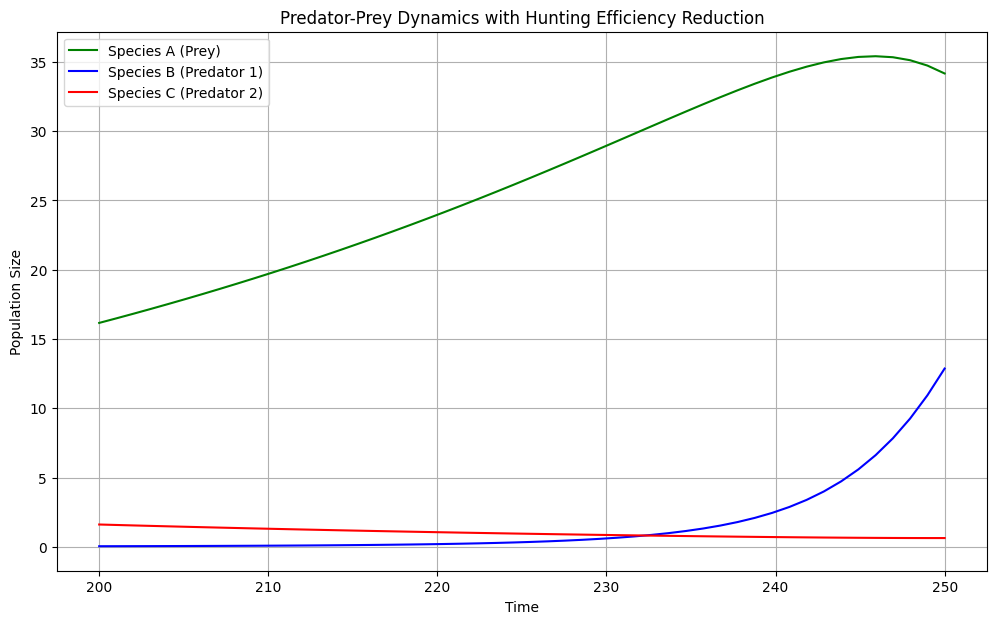

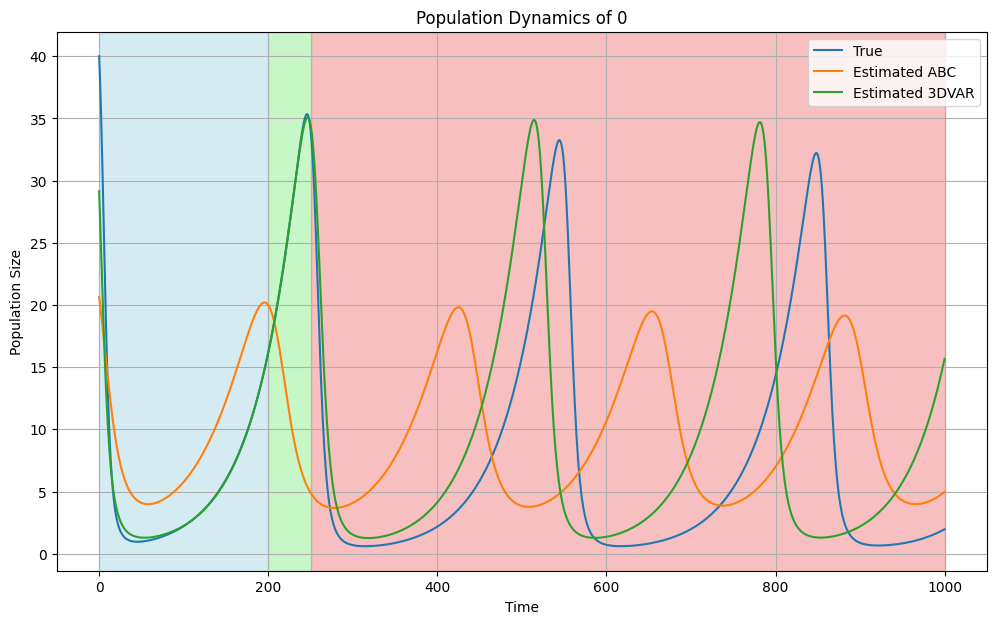

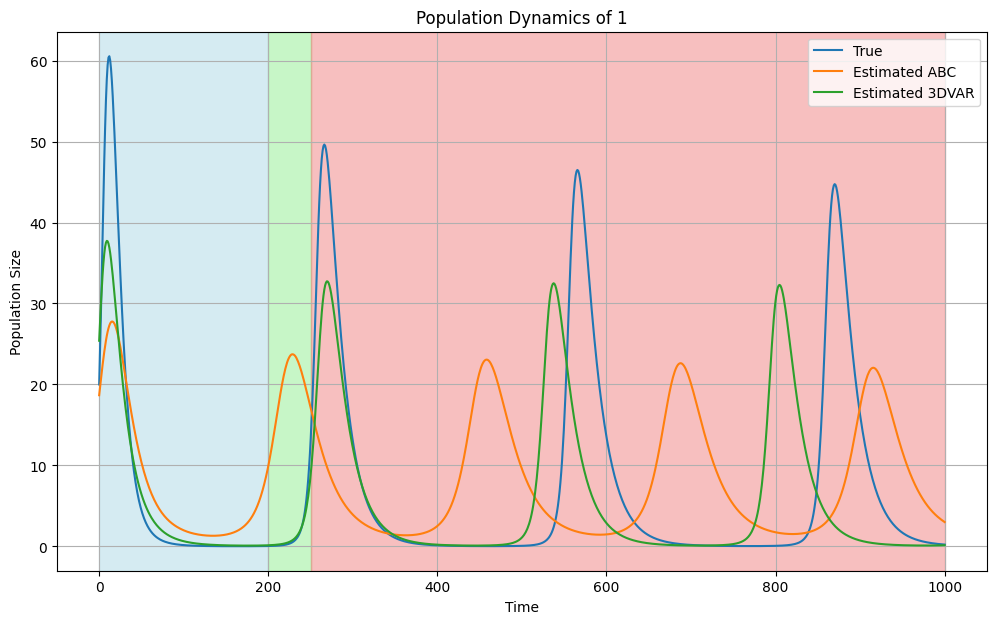

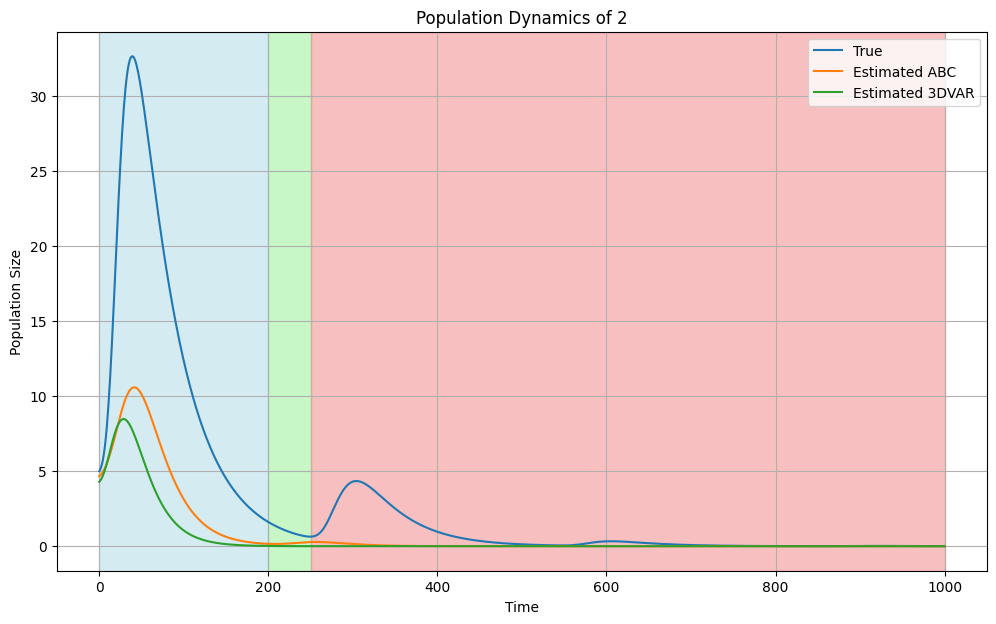

RMSE ABC: 9.6
RMSE 3DVAR: 7.1


In [156]:
def test_training_interval(training_interval, base_params, start_params):
    
    #base data
    training_sol = evaluate_model_and_plot(
        predator_prey_ode, 
        base_params, 
        [   
            base_params['initial_population_A'], 
            base_params['initial_population_B'], 
            base_params['initial_population_C']
        ],
        t_eval= np.linspace(training_interval[0], training_interval[1],training_interval[1]- training_interval[0]),
        plot=True
    )
    
    params_prior = {key: (prior * 0.6, prior * 1.4) for key, prior in start_params.items()}
    
    #abc
    accepted_params_abc = abc_assimilation(
        training_sol.y, 
        np.linspace( training_interval[0], training_interval[1], training_interval[1]- training_interval[0] ),
        params_prior,
        num_samples
    )
    
    estimated_params_abc = {
        key: np.mean([p[key] for _dist, p in accepted_params_abc]) for key in params_prior
    }
    
    #3dvar
    std = 1
    params_template = base_params.copy()
    params_vec_init = [
        uniform.rvs(loc=prior[0], scale=prior[1] - prior[0], random_state=1)
        for prior in params_prior.values()
    ]
    accepted_params_3dvar = minimize(
        cost_function_3dvar,
        params_vec_init,
        args=(
            training_sol.y,
            np.linspace(training_interval[0], training_interval[1], training_interval[1]- training_interval[0]),
            params_template,
            params_prior,
            std**2,
        ),
    )
    estimated_params_3dvar = params_template.copy()
    i = 0
    for key in estimated_params_3dvar:
        estimated_params_3dvar[key] = accepted_params_3dvar.x[i]
        i += 1
    
    #evaluate
    t_eval = np.linspace(0, 1000, 1000)
    
    y_values, y_values_abc, y_values_3dvar = (
        solve_ivp(
            predator_prey_ode,
            (0, 1000),
            [   
                base_params['initial_population_A'], 
                base_params['initial_population_B'], 
                base_params['initial_population_C']
            ],
            args=(base_params,),
            method="BDF",
            t_eval=t_eval,
        ).y
        for base_params in (base_params, estimated_params_abc, estimated_params_3dvar)
    )
    
    intervals = [(0, training_interval[0], "lightblue"), (training_interval[0], training_interval[1], "lightgreen"), (training_interval[1], 1000, "lightcoral")]

    for i in range(3):
        plt.figure(figsize=(12, 7))
        plt.plot(t_eval, y_values[i], label="True")
        plt.plot(t_eval, y_values_abc[i], label="Estimated ABC")
        plt.plot(t_eval, y_values_3dvar[i], label="Estimated 3DVAR")
        for start, end, color in intervals:
            plt.axvspan(start, end, color=color, alpha=0.5)
        plt.xlabel("Time")
        plt.ylabel("Population Size")
        plt.title(f"Population Dynamics of {i}")
        plt.legend()
        plt.grid()
        plt.show()
    
    rmse_abc = root_mean_squared_error(y_values, y_values_abc) 
    rmse_3dvar = root_mean_squared_error(y_values, y_values_3dvar)
    
    print(f"RMSE ABC: {rmse_abc:.1f}")
    print(f"RMSE 3DVAR: {rmse_3dvar:.1f}")
        
    
test_training_interval((200, 250), base_model_params, start_model_params)    

first variable got correctly assimilated by 3dvar

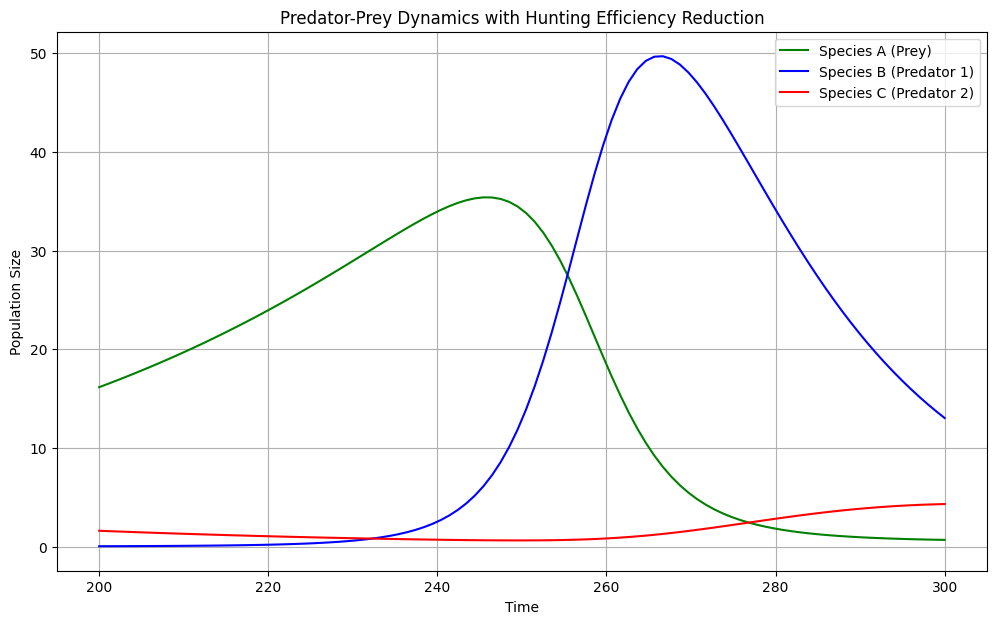

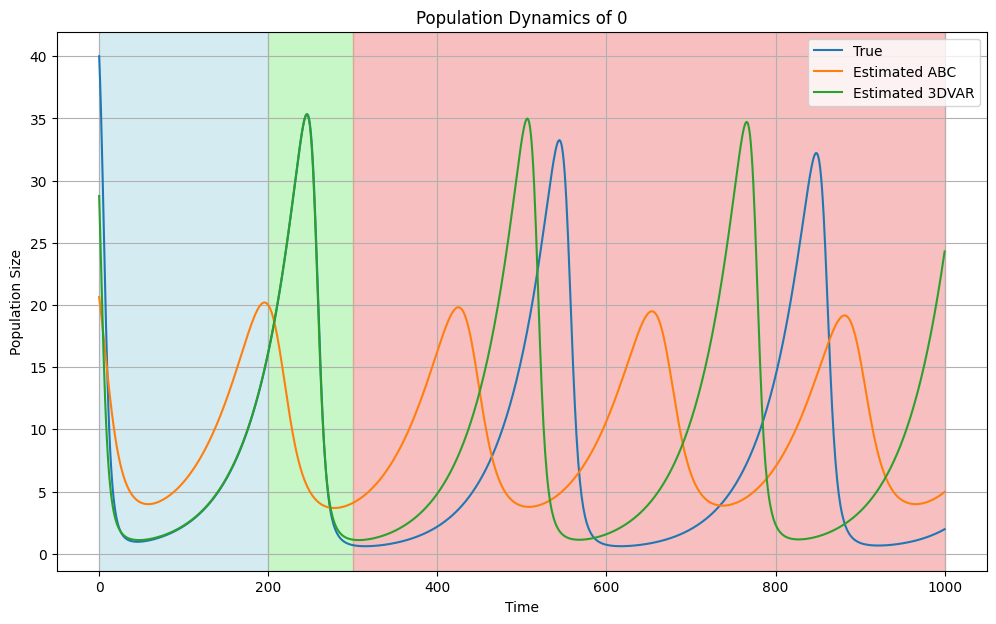

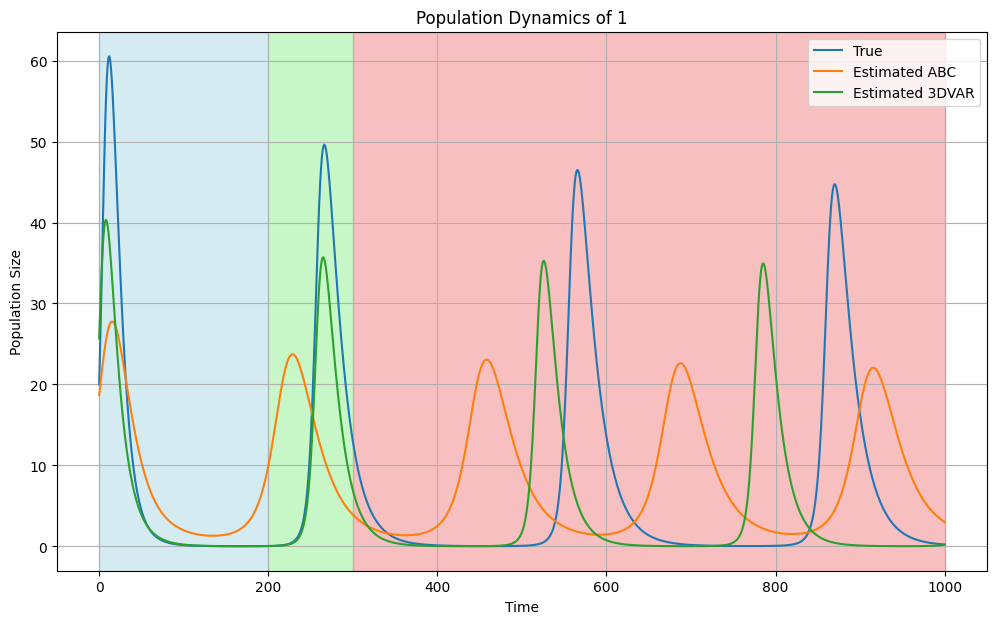

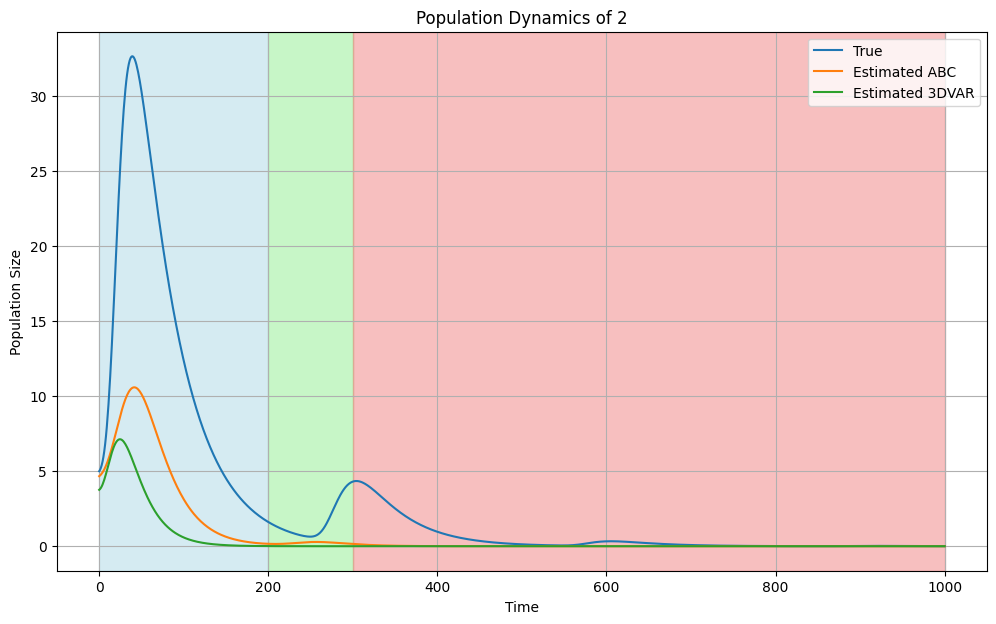

RMSE ABC: 9.6
RMSE 3DVAR: 8.1


In [157]:
test_training_interval((200, 300), base_model_params, start_model_params)    

results worse than on shorter training interval

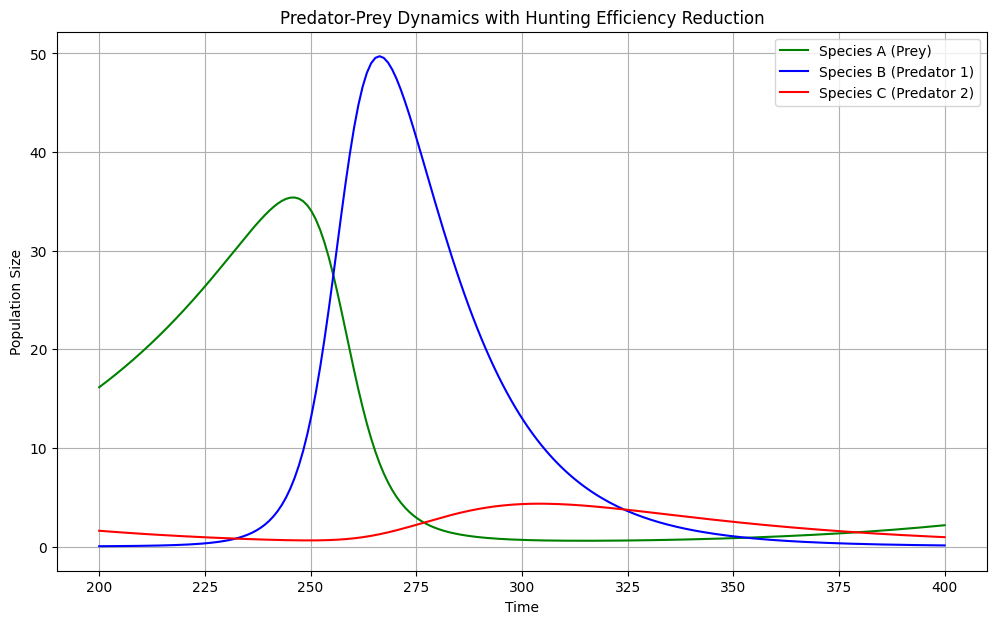

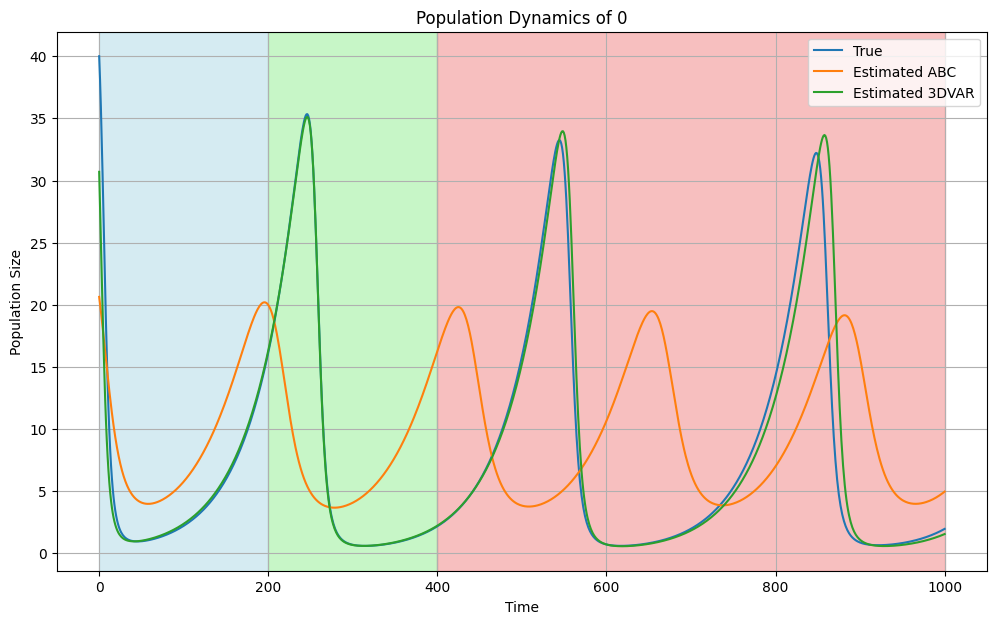

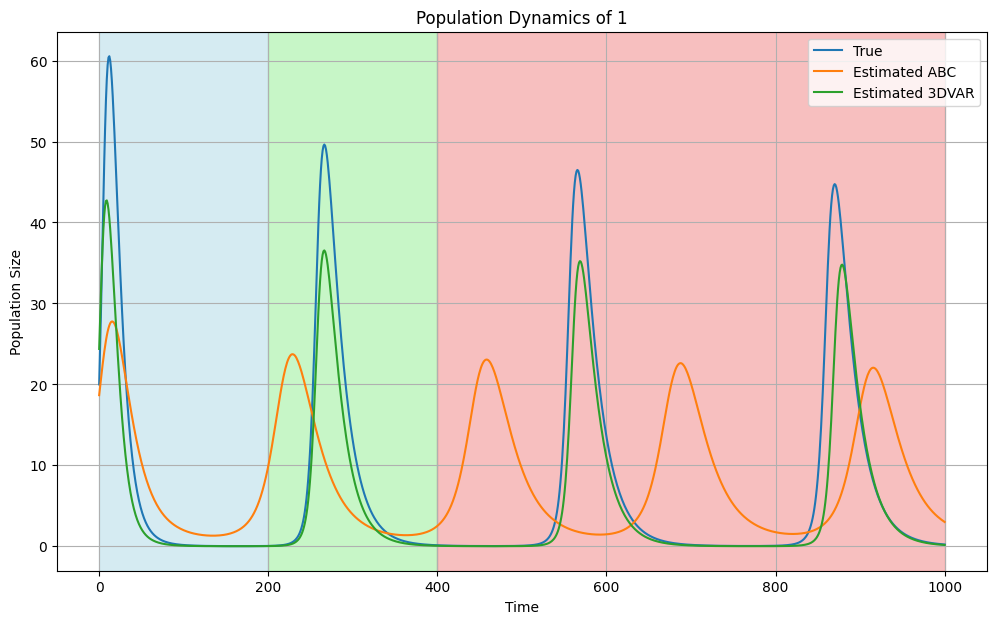

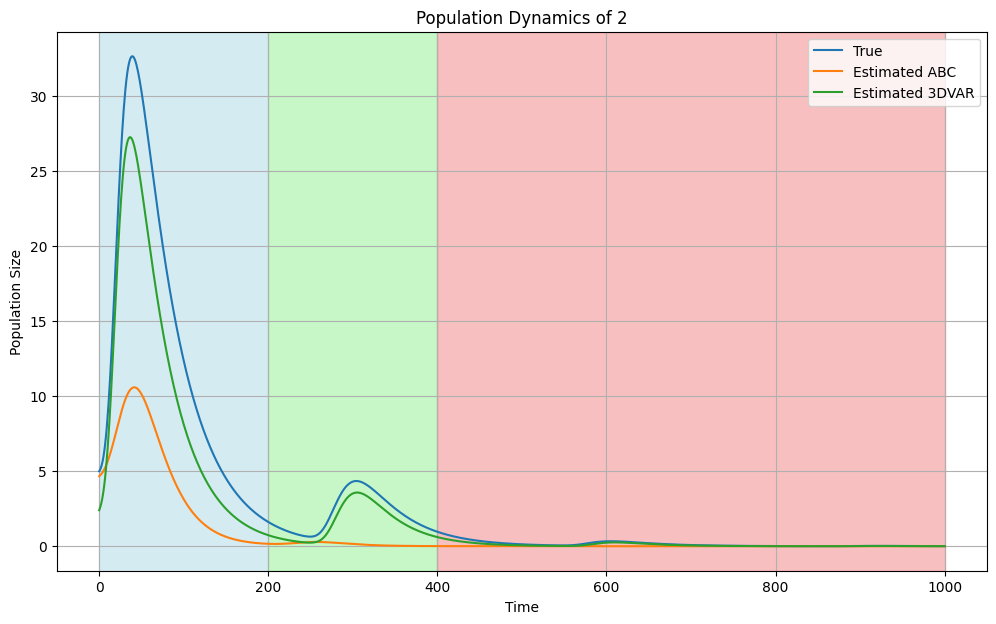

RMSE ABC: 9.6
RMSE 3DVAR: 1.9


In [158]:
test_training_interval((200, 400), base_model_params, start_model_params)    

3d var almost ideally got it right

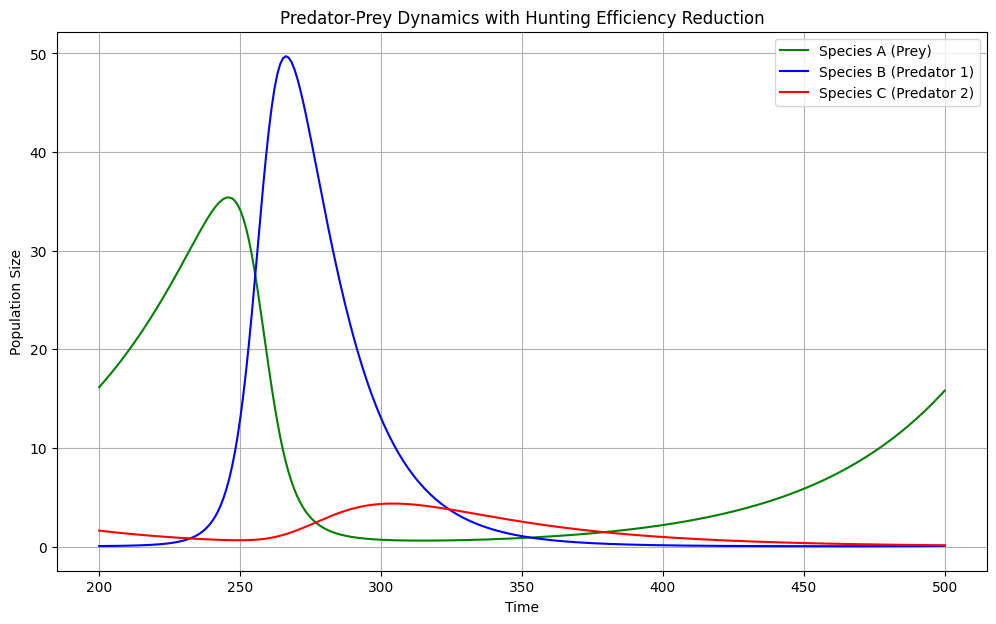

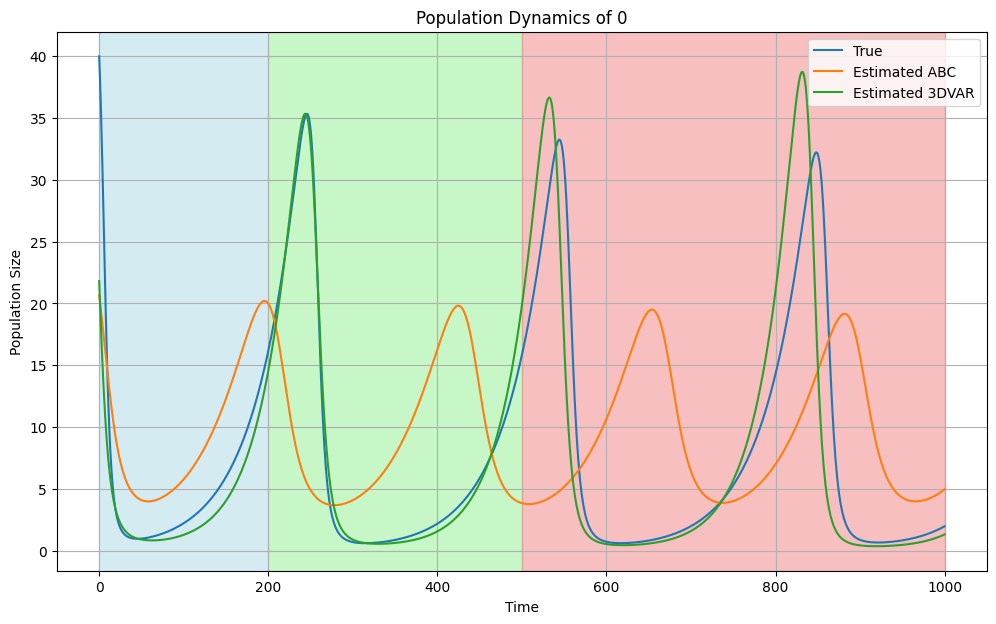

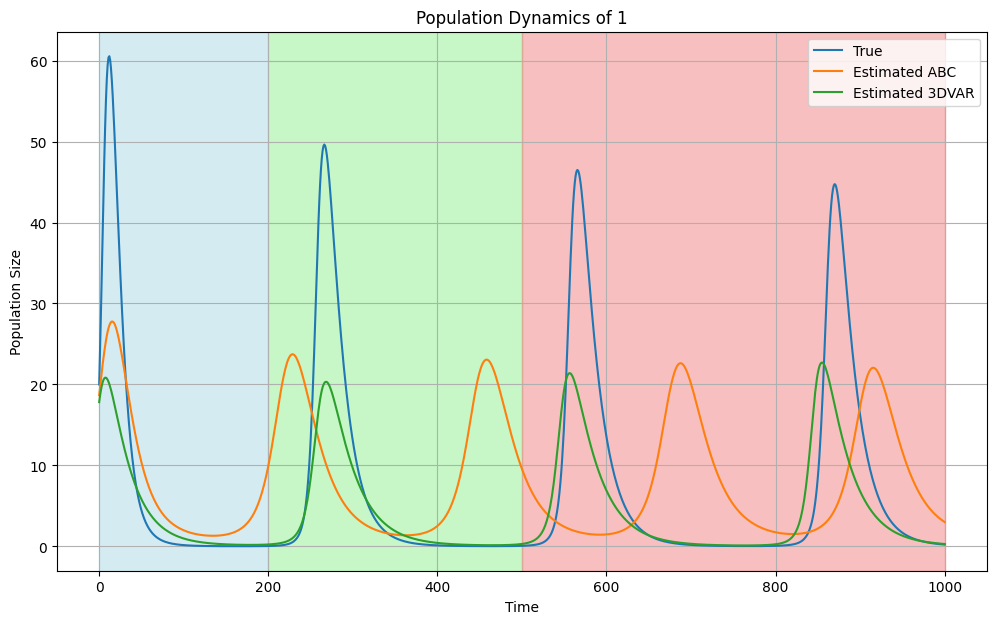

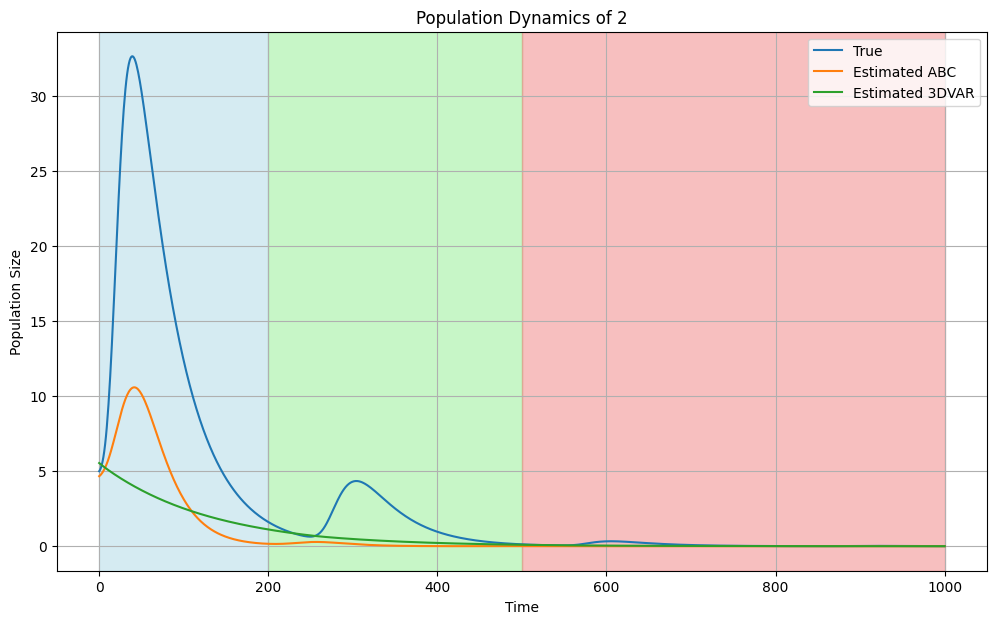

RMSE ABC: 9.6
RMSE 3DVAR: 4.3


In [161]:
test_training_interval((200, 500), base_model_params, start_model_params)    

ABC was insensitive to training interval. 3dvar got it right, but best on interval that matched one cycle. Anything larger/smaller got worse results